## Single scale input vs. Multi-scale input vs. Gated multi-scale input

In [1]:
import os
os.chdir('..')
from glob import glob
from notebooks import config
import numpy as np
import pandas as pd
import seaborn as sns
from utils.imgShow import imgShow, imsShow
import matplotlib.pyplot as plt
from utils.metrics_plot import csv_merge, smooth
from utils.metric import acc_matrix, acc_miou
from utils.raster_vec import vec2mask
from utils.geotif_io import readTiff
from matplotlib.pyplot import MultipleLocator
from matplotlib.colors import ListedColormap

### 1. Calculate metrics (miou/oa/prod/user) for all test site scenes (only for new method).

In [2]:
path_testsite_scene = glob(config.root_proj + '/data/dset/s1_as_des/*')
path_testsite_scene.sort()
path_testsite_truth = glob(config.root_proj + '/data/dset/s1_truth/*0?_wat*.tif')
path_testsite_truth.sort()
path_testsite_wat_gscales = glob(config.root_proj + '/data/dset/s1_water_test_gscales/*')
path_testsite_wat_gscales.sort()


In [3]:
oa, miou, prod, user = [], [], [], []
scenes, truths, wats = [], [], []
for idx in range(7):
    scene, scene_info = readTiff(path_testsite_scene[idx])
    truth, truth_info = readTiff(path_testsite_truth[idx])
    wat, wat_info = readTiff(path_testsite_wat_gscales[idx])
    scenes.append(scene); truths.append(truth); wats.append(wat)
    oa_i, prod_i, user_i, confus_mat_i = acc_matrix(cla_map=wat, truth_map=truth, id_label=1)
    miou_i = acc_miou(cla_map=wat, truth_map=truth, labels=[1])
    oa.append(float(format(oa_i, '.4f'))), miou.append(float(format(miou_i, '.4f')))
    prod.append(float(format(prod_i, '.4f'))), user.append(float(format(user_i, '.4f')))

oa_m, miou_m = float(format(np.mean(oa), '.4f')), float(format(np.mean(miou), '.4f'))
prod_m, user_m = float(format(np.mean(prod), '.4f')), float(format(np.mean(user), '.4f'))


In [4]:
print('oa:', oa)
print('miou:', miou)
print('prod:', prod)
print('user:', user)
print('oa_mean:', oa_m, 'miou_mean:', miou_m, 'prod_mean:', prod_m, 'user_mean:', user_m)


oa: [0.9977, 0.9854, 0.9775, 0.9627, 0.996, 0.9949, 0.9964]
miou: [0.9807, 0.8779, 0.9213, 0.6175, 0.9567, 0.9788, 0.9897]
prod: [0.9902, 0.9167, 0.9428, 0.6759, 0.9962, 0.9943, 0.9964]
user: [0.9904, 0.954, 0.9758, 0.8772, 0.9602, 0.9844, 0.9933]
oa_mean: 0.9872 miou_mean: 0.9032 prod_mean: 0.9304 user_mean: 0.9622


#### Show the derived water maps

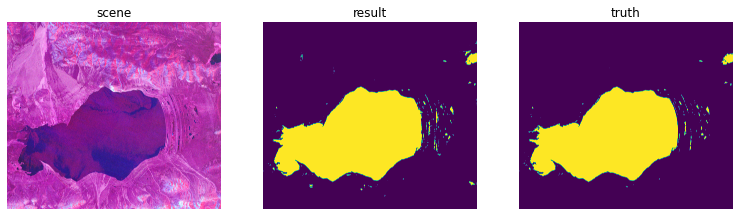

In [5]:
idx = 5
img_list = [scenes[idx], wats[idx], truths[idx]]
img_name_list = ['scene', 'result', 'truth']
clip_list = [2,0,0]
plt.figure(figsize=(13, 8))
imsShow(img_list, img_name_list, clip_list, \
                    color_bands_list=None, axis=None, row=None, col=None)


### 2. Comparison among methods (plot smoothed metric for one test)

In [6]:
##### single -> 1: 87.0; scales -> 4: 94.3; gscales -> 9: 95.5. -> 2: 95.4
####################################################################
## 1. Model name and the selected metric
# id_model =  '10'
# model_name = ['model_single_test_'+id_model, 'model_scales_test_'+id_model, 'model_gscales_test_'+id_model]
model_name = ['model_single_test_1', 'model_scales_test_4', 'model_gscales_test_9']

# metric_name = 'val_miou'
path_metrics_single = config.root_proj + '/model/pretrained/model_single_test/' + model_name[0] + '_metrics.csv'
path_metrics_scales = config.root_proj + '/model/pretrained/model_scales_test/' + model_name[1] + '_metrics.csv'
path_metrics_gscales = config.root_proj + '/model/pretrained/model_gscales_test/' + model_name[2] + '_metrics.csv'

## 2. Read metric file (each file corresponding to one model and contains all metrics)
metrics_single = pd.read_csv(path_metrics_single)
metrics_scales = pd.read_csv(path_metrics_scales)
metrics_gscales = pd.read_csv(path_metrics_gscales)
# metrics_single.tail()
metrics_gscales.tail(2)



,tra_loss,tra_miou,val_loss,val_miou
198,0.338212,0.948515,0.135021,0.955917
199,0.339140,0.955695,0.135468,0.954634


In [7]:
### metrics smooth
metrics_single_smooth_x, metrics_single_smooth_y = smooth(metrics_single['val_miou'].to_numpy(), num_sam=20)
metrics_scales_smooth_x, metrics_scales_smooth_y = smooth(metrics_scales['val_miou'].to_numpy(), num_sam=20)
metrics_gscales_smooth_x, metrics_gscales_smooth_y = smooth(metrics_gscales['val_miou'].to_numpy(), num_sam=20)



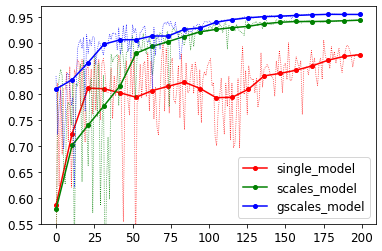

In [8]:
plt.rcParams.update({'font.size': 12})
color = ['red', 'green', 'blue']
plt.plot(metrics_single['val_miou'], color=color[0], linestyle='dotted', linewidth = 0.7)
plt.plot(metrics_single_smooth_x, metrics_single_smooth_y, color=color[0], \
            marker='o', markerfacecolor=color[0], markersize=4, linewidth=1.5, label= 'single_model')
plt.plot(metrics_scales['val_miou'], color=color[1], linestyle='dotted', linewidth = 0.7)
plt.plot(metrics_scales_smooth_x, metrics_scales_smooth_y, color=color[1], \
            marker='o', markerfacecolor = color[1], markersize=4, linewidth = 1.5,label= 'scales_model')

plt.plot(metrics_gscales['val_miou'], color=color[2], linestyle='dotted', linewidth = 0.7)
plt.plot(metrics_gscales_smooth_x, metrics_gscales_smooth_y, color=color[2], \
            marker='o', markerfacecolor=color[2], markersize=4, linewidth = 1.5, label= 'gscales_model')
plt.ylim(top=0.97, bottom=0.55)
plt.legend()


### 3. Comparison among methods (plot metric line with confidence interval)


In [9]:
### metrics path
dir_metric_gscales = config.root_proj + '/model/pretrained/model_gscales_test'
paths_metric_gscales = glob(dir_metric_gscales + '/*metrics*')
dir_metric_scales = config.root_proj + '/model/pretrained/model_scales_test'
paths_metric_scales = glob(dir_metric_scales + '/*metrics*')
dir_metric_single = config.root_proj + '/model/pretrained/model_single_test'
paths_metric_single = glob(dir_metric_single + '/*metrics*')


### Concat metrics obtained by different iteration

In [10]:
metrics_gscales = csv_merge(paths_metric_gscales, new_col='i_test', sam=5)
metrics_scales = csv_merge(paths_metric_scales, new_col='i_test', sam=5)
metrics_single = csv_merge(paths_metric_single, new_col='i_test', sam=5)
metrics_models = csv_merge([metrics_single, metrics_scales, metrics_gscales], new_col='i_model')

print(metrics_models.head())
print('gscales model: ',metrics_gscales.shape)
print('models:', metrics_models.shape)



   tra_loss  tra_miou  val_loss  val_miou  epoch  i_test  i_model
0  0.578091  0.575887  0.395957  0.507823      1       1        1
1  0.429618  0.770328  0.203040  0.842102      6       1        1
2  0.425312  0.769982  0.236015  0.796362     11       1        1
3  0.419432  0.776269  0.206365  0.857890     16       1        1
4  0.439303  0.741113  0.228727  0.860664     21       1        1
gscales model:  (400, 6)
models: (1200, 7)


In [11]:
### change the column name and the corresponding values
metrics_models_ = metrics_models.rename(columns={'i_model': 'Model'})
metrics_models_['Model'] = metrics_models_['Model'].replace([1], 'Single scale')
metrics_models_['Model'] = metrics_models_['Model'].replace([2], 'Multiple scales')
metrics_models_['Model'] = metrics_models_['Model'].replace([3], 'Gated multiple scales')


### Plot epoch-val_miou figure.

Text(0, 0.5, 'Validation MIoU (%)')

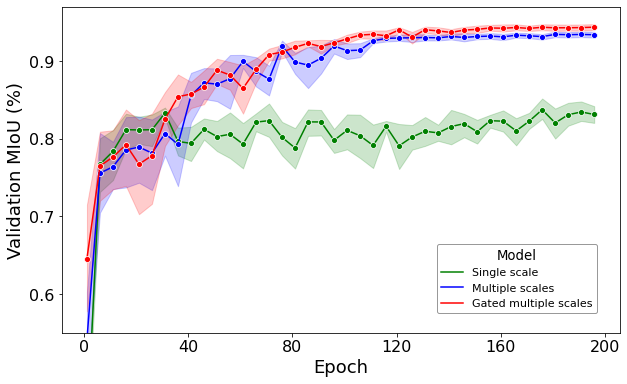

In [12]:
plt.rcParams.update({'font.size': 16})
colors = ['green', 'blue', 'red']

fig = plt.figure(figsize=(10,6))
ax_1 = fig.add_subplot(111)
sns.lineplot(data=metrics_models_, x='epoch', y='val_miou', \
                hue='Model', palette=colors, marker='o', \
                ci=90, ax=ax_1)

# ax.legend().set_visible(False)
ax_1.legend(title ='Model', title_fontsize='small', edgecolor='0.5', \
          fontsize='x-small', loc='upper right', bbox_to_anchor=(0.47, -0.21, 0.5, 0.5))
ax_1.set_ylim(top=0.97, bottom=0.55)
y_major_locator=MultipleLocator(0.1)
ax_1.yaxis.set_major_locator(y_major_locator)
x_major_locator=MultipleLocator(40)
ax_1.xaxis.set_major_locator(x_major_locator)
ax_1.set_xlabel('Epoch', fontsize=18) 
ax_1.set_ylabel('Validation MIoU (%)', fontsize=18)
# plt.savefig(config.root_proj + '/figure/miou_methods_compare.png', bbox_inches='tight')


Text(0, 0.5, 'Validation MIoU (%)')

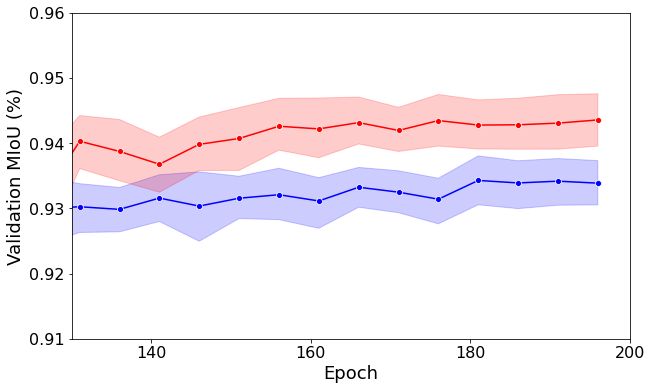

In [13]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
sns.lineplot(data=metrics_models_, x='epoch', y='val_miou', \
                hue='Model', palette=colors, marker='o', \
                ci=90, ax=ax)

ax.legend().set_visible(False)
ax.set_ylim(top=0.96, bottom=0.91)
ax.set_xlim(left=130, right=200)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(0.01)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
ax.set_xlabel('Epoch', fontsize=18) 
ax.set_ylabel('Validation MIoU (%)', fontsize=18)
# plt.savefig(config.root_proj + '/figure/miou_methods_compare.png', bbox_inches='tight')



### Plot epoch-val_loss figure.

Text(0, 0.5, 'Validation loss')

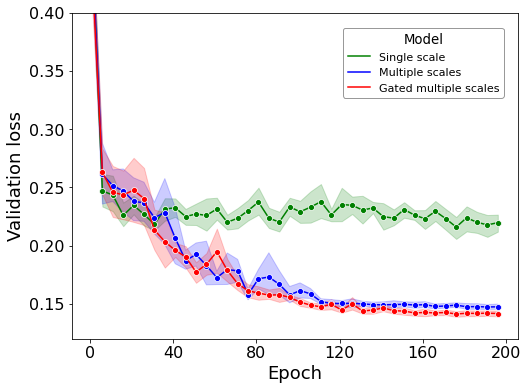

In [14]:
plt.rcParams.update({'font.size': 16})
colors = ['green', 'blue', 'red']

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.lineplot(data=metrics_models_, x='epoch', y='val_loss', \
                hue='Model', palette=colors, marker='o', \
                ci=90, ax=ax)

# ax.legend().set_visible(False)
ax.legend(title ='Model', title_fontsize='small', edgecolor='0.5', \
          fontsize='x-small', loc='upper right', bbox_to_anchor=(0.48, 0.47, 0.5, 0.5))
ax.set_ylim(top=0.4, bottom=0.12)
x_major_locator=MultipleLocator(40)
y_major_locator=MultipleLocator(0.05)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
ax.set_xlabel('Epoch', fontsize=18) 
ax.set_ylabel('Validation loss', fontsize=18)
# plt.savefig(config.root_proj + '/figure/loss_methods_compare.png', bbox_inches='tight')



Text(0, 0.5, 'Validation loss')

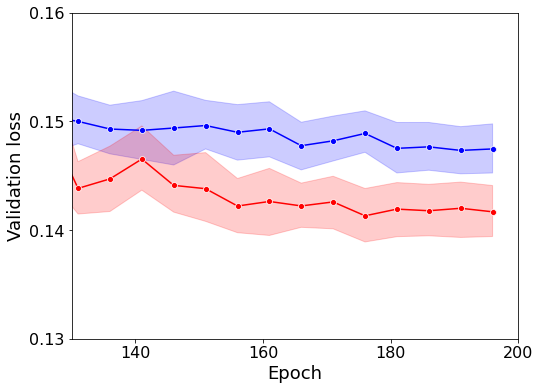

In [15]:
plt.rcParams.update({'font.size': 16})
colors = ['green', 'blue', 'red']
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.lineplot(data=metrics_models_, x='epoch', y='val_loss', \
                  hue='Model', palette=colors, marker='o', ci=90, ax=ax)
ax.legend().set_visible(False)
ax.set_xlim(left=130, right=200)
ax.set_ylim(top=0.16, bottom=0.13)
x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(0.01)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
ax.set_xlabel('Epoch', fontsize=18) 
ax.set_ylabel('Validation loss', fontsize=18)
# plt.savefig(config.root_proj + '/figure/loss_methods_compare.png', bbox_inches='tight')



### **Visualize the results derived by methods**

In [6]:
path_testsite_s2 = glob(config.root_proj + '/data/dset/s2_img/*')
path_testsite_wat_scales = glob(config.root_proj + '/data/dset/s1_water_test_scales/*')
path_testsite_wat_single = glob(config.root_proj + '/data/dset/s1_water_test_single/*')
path_testsite_s2.sort()
path_testsite_s2 = path_testsite_s2[0:7]
path_testsite_wat_scales.sort()
path_testsite_wat_single.sort()
# path_testsite_s2


In [7]:
scenes, truths = [], []
s2_scenes = []
wats_single, wats_scales, wats_gscales = [], [], []
for idx in range(7):
    scene, scene_info = readTiff(path_testsite_scene[idx])
    s2_scene, s2_scene_info = readTiff(path_testsite_s2[idx])
    truth, truth_info = readTiff(path_testsite_truth[idx])
    wat_gscales, wat_gscales_info = readTiff(path_testsite_wat_gscales[idx])
    wat_scales, wat_scales_info = readTiff(path_testsite_wat_scales[idx])
    wat_single, wat_single_info = readTiff(path_testsite_wat_single[idx])    
    scenes.append(scene); truths.append(truth); 
    s2_scenes.append(s2_scene)
    wats_gscales.append(wat_gscales); wats_scales.append(wat_scales); wats_single.append(wat_single)


In [10]:
def local_dif(s1_scene, s2_scene, truth, wat_gscales, wat_scales, wat_single, region):
    ### focus on a local region 
    row_start, row_end, col_start, col_end = region
    s1_scene_l = s1_scene[row_start:row_end,col_start:col_end]
    s2_scene_l = s2_scene[row_start:row_end,col_start:col_end]
    truth_l = truth[row_start:row_end,col_start:col_end]
    wat_gscales_l = wat_gscales[row_start:row_end,col_start:col_end]
    wat_scales_l = wat_scales[row_start:row_end,col_start:col_end]
    wat_single_l = wat_single[row_start:row_end,col_start:col_end]
    ### calculate difference
    dif_gscales_l = (truth_l+1)*2 - wat_gscales_l
    dif_scales_l = (truth_l+1)*2 - wat_scales_l
    dif_single_l = (truth_l+1)*2 - wat_single_l
    return s1_scene_l, s2_scene_l, truth_l, dif_gscales_l, dif_scales_l, dif_single_l


### Small-size water recognition （!!single-scale model supervior to gscale model）

size: (3333, 3811)


Text(0.5, 1.0, 'single model')

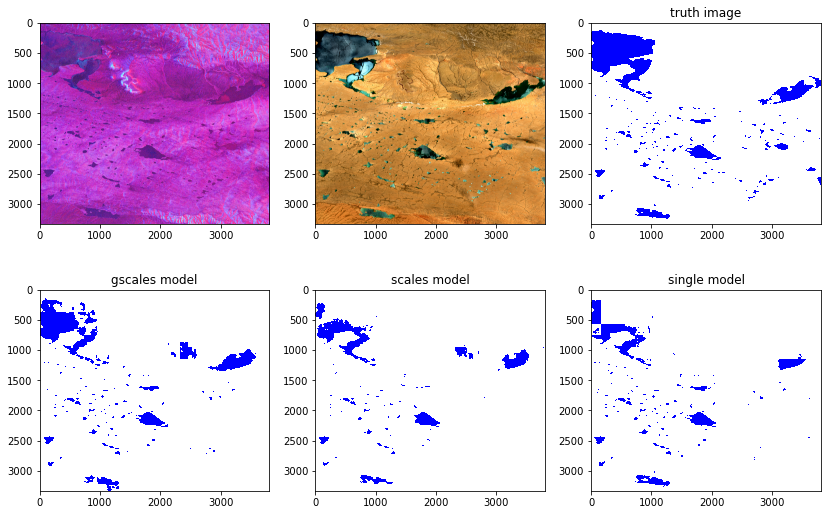

In [8]:
idx = 3
print('size:', truths[idx].shape)
cmap_wat = ListedColormap(["white", "blue"])
plt.figure(figsize=(14,9))
plt.subplot(2,3,1); imgShow(scenes[idx])
plt.subplot(2,3,2); imgShow(s2_scenes[idx])
plt.subplot(2,3,3); plt.imshow(truths[idx], cmap=cmap_wat); plt.title('truth image')
plt.subplot(2,3,4); plt.imshow(wats_gscales[idx], cmap=cmap_wat); plt.title('gscales model')
plt.subplot(2,3,5); plt.imshow(wats_scales[idx], cmap=cmap_wat); plt.title('scales model')
plt.subplot(2,3,6); plt.imshow(wats_single[idx], cmap=cmap_wat); plt.title('single model')



Text(0.5, 1.0, 'single model')

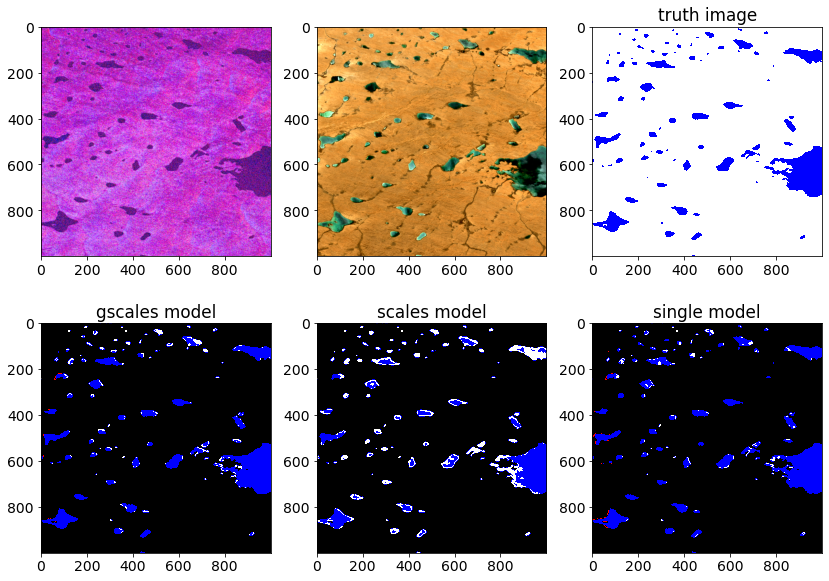

In [11]:
plt.rcParams.update({'font.size': 14})
cmap_truth = ListedColormap(["white", "blue"])
cmap_dif = ListedColormap(['red', 'black', 'blue','white'])

row_start, row_end = 1500, 2500
col_start, col_end = 800, 1800
region = [row_start, row_end, col_start, col_end]

s1_scene_l, s2_scene_l, truth_l, dif_gscales_l, dif_scales_l, dif_single_l = local_dif(scenes[idx], \
              s2_scenes[idx], truths[idx], wats_gscales[idx], wats_scales[idx], wats_single[idx], region)

plt.figure(figsize=(14,10))

plt.subplot(2,3,1); imgShow(s1_scene_l)
plt.subplot(2,3,2); imgShow(s2_scene_l)
plt.subplot(2,3,3); plt.imshow(truth_l, cmap=cmap_truth); plt.title('truth image')
plt.subplot(2,3,4); plt.imshow(dif_gscales_l, cmap=cmap_dif); plt.title('gscales model')
plt.subplot(2,3,5); plt.imshow(dif_scales_l, cmap=cmap_dif); plt.title('scales model')
plt.subplot(2,3,6); plt.imshow(dif_single_l, cmap=cmap_dif); plt.title('single model')



### Easy water body -> scene1 (✓1)

size: (3472, 3874)


Text(0.5, 1.0, 'single model')

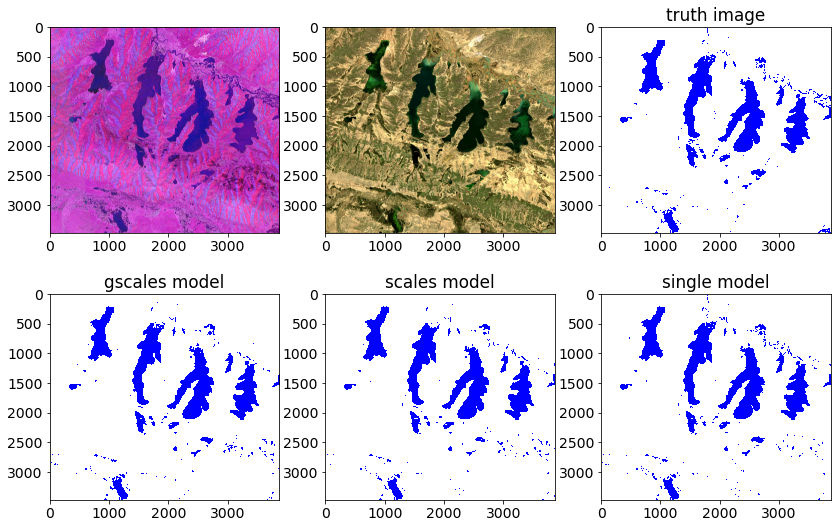

In [12]:
idx = 1
img_list = [scenes[idx], s2_scenes[idx], truths[idx], wats_gscales[idx], wats_scales[idx], wats_single[idx]]
print('size:', truths[idx].shape)
cmap_wat = ListedColormap(["white", "blue"])
plt.figure(figsize=(14,9))
plt.subplot(2,3,1); imgShow(scenes[idx])
plt.subplot(2,3,2); imgShow(s2_scenes[idx])
plt.subplot(2,3,3); plt.imshow(truths[idx], cmap=cmap_wat); plt.title('truth image')
plt.subplot(2,3,4); plt.imshow(wats_gscales[idx], cmap=cmap_wat); plt.title('gscales model')
plt.subplot(2,3,5); plt.imshow(wats_scales[idx], cmap=cmap_wat); plt.title('scales model')
plt.subplot(2,3,6); plt.imshow(wats_single[idx], cmap=cmap_wat); plt.title('single model')


Text(0.5, 1.0, 'single model')

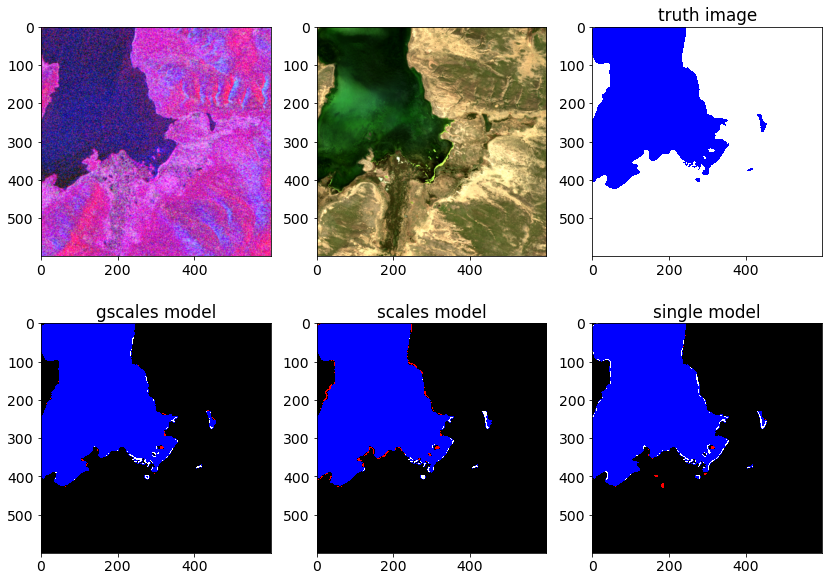

In [13]:
plt.rcParams.update({'font.size': 14})

row_start, row_end = 700, 1300
col_start, col_end = 700, 1300

region = [row_start, row_end, col_start, col_end]

s1_scene_l, s2_scene_l, truth_l, dif_gscales_l, dif_scales_l, dif_single_l = local_dif(scenes[idx], \
              s2_scenes[idx], truths[idx], wats_gscales[idx], wats_scales[idx], wats_single[idx], region)

plt.figure(figsize=(14,10))

plt.subplot(2,3,1); imgShow(s1_scene_l)
plt.subplot(2,3,2); imgShow(s2_scene_l)
plt.subplot(2,3,3); plt.imshow(truth_l, cmap=cmap_truth); plt.title('truth image')
plt.subplot(2,3,4); plt.imshow(dif_gscales_l, cmap=cmap_dif); plt.title('gscales model')
plt.subplot(2,3,5); plt.imshow(dif_scales_l, cmap=cmap_dif); plt.title('scales model')
plt.subplot(2,3,6); plt.imshow(dif_single_l, cmap=cmap_dif); plt.title('single model')



### Hard water body -> scene2 (✓2)

size: (3509, 3962)


Text(0.5, 1.0, 'single model')

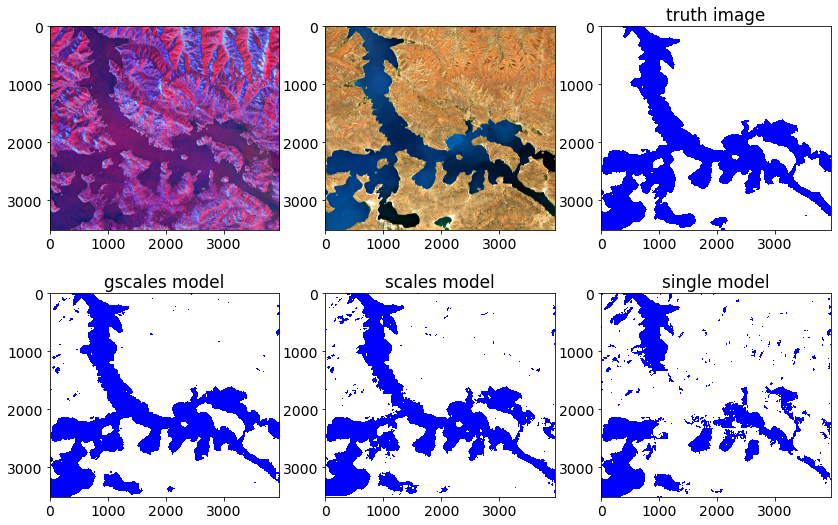

In [14]:
idx = 2
img_list = [scenes[idx], s2_scenes[idx], truths[idx], wats_gscales[idx], wats_scales[idx], wats_single[idx]]
print('size:', truths[idx].shape)
cmap_wat = ListedColormap(["white", "blue"])
plt.figure(figsize=(14,9))
plt.subplot(2,3,1); imgShow(scenes[idx])
plt.subplot(2,3,2); imgShow(s2_scenes[idx])
plt.subplot(2,3,3); plt.imshow(truths[idx], cmap=cmap_wat); plt.title('truth image')
plt.subplot(2,3,4); plt.imshow(wats_gscales[idx], cmap=cmap_wat); plt.title('gscales model')
plt.subplot(2,3,5); plt.imshow(wats_scales[idx], cmap=cmap_wat); plt.title('scales model')
plt.subplot(2,3,6); plt.imshow(wats_single[idx], cmap=cmap_wat); plt.title('single model')



Text(0.5, 1.0, 'single model')

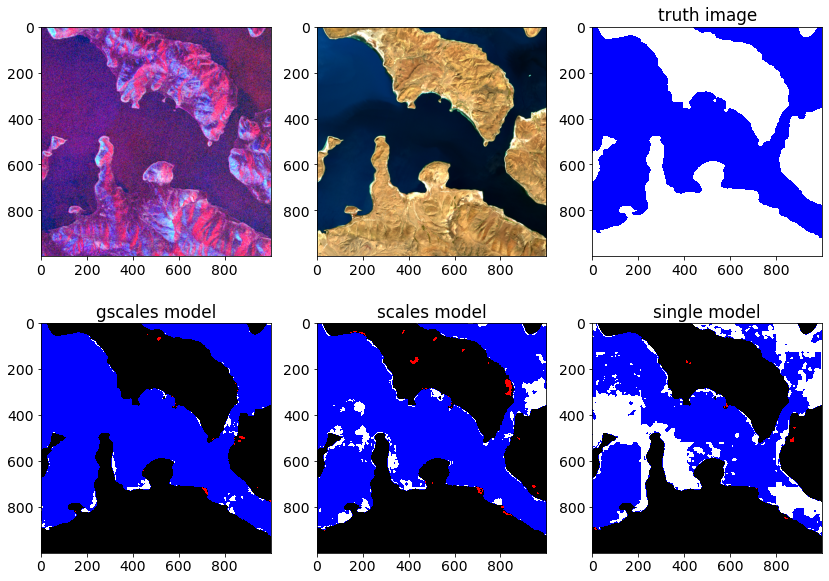

In [15]:
plt.rcParams.update({'font.size': 14})

row_start, row_end = 2000, 3000
col_start, col_end = 2500, 3500
region = [row_start, row_end, col_start, col_end]

s1_scene_l, s2_scene_l, truth_l, dif_gscales_l, dif_scales_l, dif_single_l = local_dif(scenes[idx], \
              s2_scenes[idx], truths[idx], wats_gscales[idx], wats_scales[idx], wats_single[idx], region)

plt.figure(figsize=(14,10))

plt.subplot(2,3,1); imgShow(s1_scene_l)
plt.subplot(2,3,2); imgShow(s2_scene_l)
plt.subplot(2,3,3); plt.imshow(truth_l, cmap=cmap_truth); plt.title('truth image')
plt.subplot(2,3,4); plt.imshow(dif_gscales_l, cmap=cmap_dif); plt.title('gscales model')
plt.subplot(2,3,5); plt.imshow(dif_scales_l, cmap=cmap_dif); plt.title('scales model')
plt.subplot(2,3,6); plt.imshow(dif_single_l, cmap=cmap_dif); plt.title('single model')


### Large-size water body -> scene6 (✓3)

size: (3296, 3519)


Text(0.5, 1.0, 'single model')

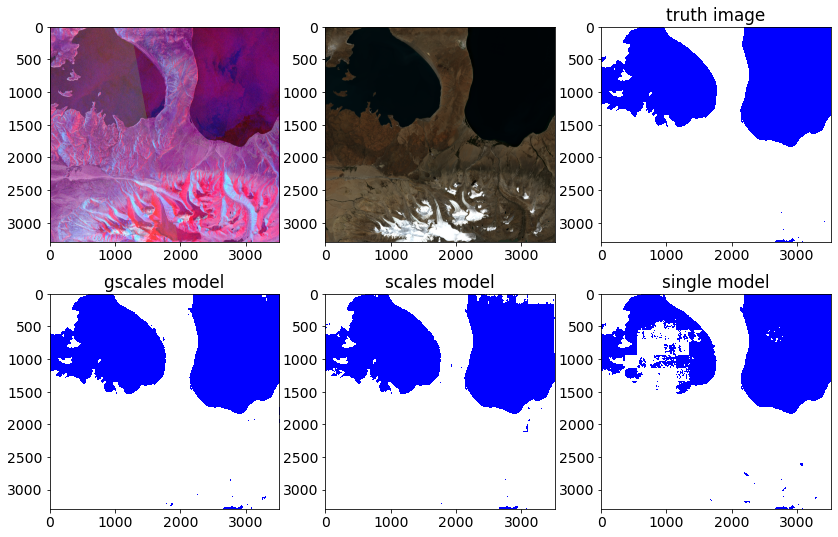

In [16]:
idx = 6
img_list = [scenes[idx], s2_scenes[idx], truths[idx], wats_gscales[idx], wats_scales[idx], wats_single[idx]]
print('size:', truths[idx].shape)
cmap_wat = ListedColormap(["white", "blue"])
plt.figure(figsize=(14,9))

plt.subplot(2,3,1); imgShow(scenes[idx])
plt.subplot(2,3,2); imgShow(s2_scenes[idx])
plt.subplot(2,3,3); plt.imshow(truths[idx], cmap=cmap_wat); plt.title('truth image')
plt.subplot(2,3,4); plt.imshow(wats_gscales[idx], cmap=cmap_wat); plt.title('gscales model')
plt.subplot(2,3,5); plt.imshow(wats_scales[idx], cmap=cmap_wat); plt.title('scales model')
plt.subplot(2,3,6); plt.imshow(wats_single[idx], cmap=cmap_wat); plt.title('single model')


Text(0.5, 1.0, 'single model')

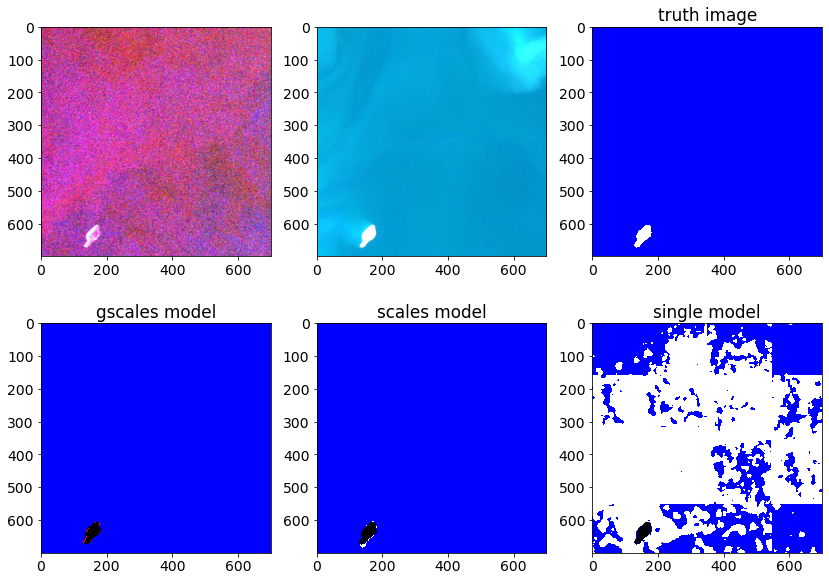

In [17]:
plt.rcParams.update({'font.size': 14})

row_start, row_end = 400, 1100
col_start, col_end = 600, 1300
region = [row_start, row_end, col_start, col_end]

s1_scene_l, s2_scene_l, truth_l, dif_gscales_l, dif_scales_l, dif_single_l = local_dif(scenes[idx], \
              s2_scenes[idx], truths[idx], wats_gscales[idx], wats_scales[idx], wats_single[idx], region)

plt.figure(figsize=(14,10))
plt.subplot(2,3,1); imgShow(s1_scene_l)
plt.subplot(2,3,2); imgShow(s2_scene_l)
plt.subplot(2,3,3); plt.imshow(truth_l, cmap=cmap_truth); plt.title('truth image')
plt.subplot(2,3,4); plt.imshow(dif_gscales_l, cmap=cmap_dif); plt.title('gscales model')
plt.subplot(2,3,5); plt.imshow(dif_scales_l, cmap=cmap_dif); plt.title('scales model')
plt.subplot(2,3,6); plt.imshow(dif_single_l, cmap=cmap_dif); plt.title('single model')

